<a href="https://colab.research.google.com/github/AntiPersnlMyne/RIT_CIS_ISAM/blob/main/RIT_ISAM_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [ ]:
!pip install opencv-python
!pip install matplotlib
import numpy as np
import cv2 as cv
from glob import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from google.colab.patches import cv2_imshow

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### File Import

In [ ]:
# Search files in Project1 for anything .tiff
filenames = []
for name in glob("/content/drive/Shareddrives/ISAM/Project1/**/*.tiff"):
  filenames.append(name)

# Sort results
filenames.sort()

# Parse names
f11 = filenames[:5]
f22 = filenames[5:10]
f56 = filenames[10:]

In [ ]:
# Create list of TIFF files. Each index is 1/5 files for that f#.
# Images read in as grayscale
tiffs_f56 = [cv.imread(file, cv.IMREAD_GRAYSCALE) for file in f56]
tiffs_f11 = [cv.imread(file, cv.IMREAD_GRAYSCALE) for file in f11]
tiffs_f22 = [cv.imread(file, cv.IMREAD_GRAYSCALE) for file in f22]

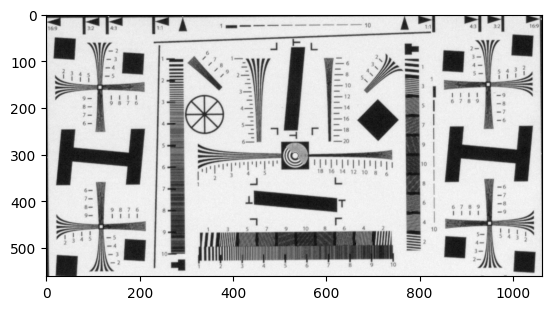

In [ ]:
# Grab first image from each f/# as crop reference
f56_crop_reference = tiffs_f56[0]
f11_crop_reference = tiffs_f11[0]
f22_crop_reference = tiffs_f22[0]

# Crop the images
f56_crop_reference = f56_crop_reference[1375:-1540, 2025:-2120]
f11_crop_reference = f11_crop_reference[1375:-1540, 1940:-2215]
f22_crop_reference = f22_crop_reference[1375:-1540, 2085:-2065]

# Verify results
plt.imshow(f56_crop_reference, cmap=mpl.colormaps['gray'])

img_height_56, img_width_56 = f56_crop_reference.shape
img_height_11, img_width_11 = f11_crop_reference.shape
img_height_22, img_width_22 = f22_crop_reference.shape


In [ ]:
# Crop the images
tiffs_f56 = [image[1375:-1540, 2025:-2120] for image in tiffs_f56]
tiffs_f11 = [image[1375:-1540, 1940:-2215] for image in tiffs_f11]
tiffs_f22 = [image[1375:-1540, 2085:-2065] for image in tiffs_f22]

In [ ]:
# Create orb detecotr with 5000 features
orb_detector = cv.ORB_create(5000)

In [ ]:
# Base/reference image to register to
ref_f56 = tiffs_f56[0]
ref_f11 = tiffs_f11[0]
ref_f22 = tiffs_f22[0]

kp_f56_ref, desc_f56_ref = orb_detector.detectAndCompute(ref_f56, None)
kp_f11_ref, desc_f11_ref = orb_detector.detectAndCompute(ref_f11, None)
kp_f22_ref, desc_f22_ref = orb_detector.detectAndCompute(ref_f22, None)

Align/register remaining images

In [ ]:
# Create output buffer
final_stack_f56 = np.zeros((img_height_56, img_width_56), dtype=np.float64)
final_stack_f11 = np.zeros((img_height_11, img_width_11), dtype=np.float64)
final_stack_f22 = np.zeros((img_height_22, img_width_22), dtype=np.float64)

# Add first image (the referfence) as first in final stack
final_stack_f56[:,:] += ref_f56[:]
final_stack_f11[:,:] += ref_f11[:]
final_stack_f22[:,:] += ref_f22[:]

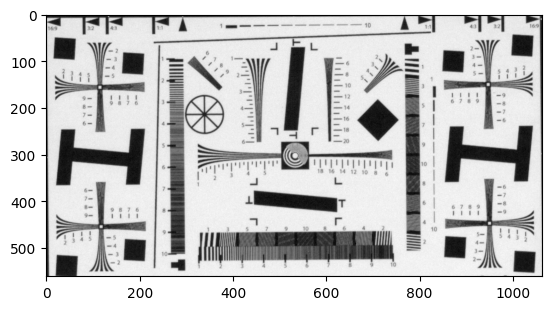

In [ ]:
# 4 remaining images in each f/#
for i in range(1, 5):

  # Define the images being registered
  # TBR = To Be Registered
  tbr_f56 = tiffs_f56[i]
  tbr_f11 = tiffs_f11[i]
  tbr_f22 = tiffs_f22[i]

  # Find (imageKeypoints (kp), imageDescriptors (desc)) for each image
  kp_f56, desc_f56 = orb_detector.detectAndCompute(tbr_f56, None)
  kp_f11, desc_f11 = orb_detector.detectAndCompute(tbr_f11, None)
  kp_f22, desc_f22 = orb_detector.detectAndCompute(tbr_f22, None)

  # Match features between the two images
  matcher = cv.BFMatcher()
  matches_f56 = matcher.match(desc_f56_ref, desc_f56) # params might be backwards
  matches_f11 = matcher.match(desc_f11_ref, desc_f11)
  matches_f22 = matcher.match(desc_f22_ref, desc_f22)

  # Sort matches by relevance
  matches_f56 = sorted(matches_f56, key=lambda x: x.distance)
  matches_f11 = sorted(matches_f11, key=lambda x: x.distance)
  matches_f22 = sorted(matches_f22, key=lambda x: x.distance)

  # take the top 90% of matches
  matches_f56 = matches_f56[:int(len(matches_f56)*0.9)]
  matches_f11 = matches_f11[:int(len(matches_f11)*0.9)]
  matches_f22 = matches_f22[:int(len(matches_f22)*0.9)]

  # Number of matches for each image
  n_matches_56 = len(matches_f56)
  n_matches_11 = len(matches_f11)
  n_matches_22 = len(matches_f22)


  # Define empty matrices of shape (nmatches, 2)
  p1_f56 = np.zeros((n_matches_56, 2))
  p1_f11 = np.zeros((n_matches_11, 2)) # TB-Regiestered
  p1_f22 = np.zeros((n_matches_22, 2))

  p2_f56 = np.zeros((n_matches_56, 2))
  p2_f11 = np.zeros((n_matches_11, 2)) # Reference
  p2_f22 = np.zeros((n_matches_22, 2))

  # Append registered image to final image stack
  for i in range(n_matches_56):
    p1_f56[i, :] = kp_f56[matches_f56[i].trainIdx].pt
    p2_f56[i, :] = kp_f56_ref[matches_f56[i].queryIdx].pt

  for i in range(n_matches_11):
    p1_f11[i, :] = kp_f11[matches_f11[i].trainIdx].pt
    p2_f11[i, :] = kp_f11_ref[matches_f11[i].queryIdx].pt

  for i in range(n_matches_22):
    p1_f22[i, :] = kp_f22[matches_f22[i].trainIdx].pt
    p2_f22[i, :] = kp_f22_ref[matches_f22[i].queryIdx].pt

  # Find the homography matrix
  homography_f56, mask_f56 = cv.findHomography(p1_f56, p2_f56, cv.RANSAC)
  homography_f11, mask_f11 = cv.findHomography(p1_f11, p2_f11, cv.RANSAC)
  homography_f22, mask_f22 = cv.findHomography(p1_f22, p2_f22, cv.RANSAC)

  # Use transformation matrix to transform the image
  transformed_f56 = cv.warpPerspective(
      tbr_f56, homography_f56, (img_width_56, img_height_56),
  )

  transformed_f11 = cv.warpPerspective(
      tbr_f11, homography_f11, (img_width_11, img_height_11),
  )

  transformed_f22 = cv.warpPerspective(
      tbr_f22, homography_f22, (img_width_22, img_height_22),
  )

  # Append transformed image to image stack
  final_stack_f56 += transformed_f56
  final_stack_f11 += transformed_f11
  final_stack_f22 += transformed_f22

  plt.imshow(transformed_f56, cmap=mpl.colormaps['gray'])


In [ ]:
# Average
final_stack_f56 /= 5
final_stack_f11 /= 5
final_stack_f22 /= 5
print(f"Array min and max (after avg): {final_stack_f56.min(), final_stack_f56.max()}")

# Convert to float32 point
final_stack_f56 = final_stack_f56.astype(np.float32)
final_stack_f11 = final_stack_f11.astype(np.float32)
final_stack_f22 = final_stack_f22.astype(np.float32)

Array min and max (after avg): (np.float64(53.2), np.float64(241.0))


In [ ]:
# Save images out to shared drive
cv.imwrite("/content/drive/Shareddrives/ISAM/Project1/registered_f5.6.png", final_stack_f56)
cv.imwrite("/content/drive/Shareddrives/ISAM/Project1/registered_f11.png", final_stack_f11)
cv.imwrite("/content/drive/Shareddrives/ISAM/Project1/registered_f22.png", final_stack_f22)


True

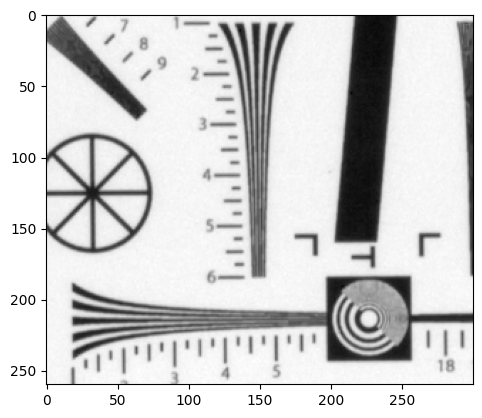

In [ ]:
# Sanity check
#plt.imshow(final_stack_f56[90:350,300:600], cmap=mpl.colormaps['gray'])
plt.imshow(final_stack_f11[90:350,300:600], cmap=mpl.colormaps['gray'])
#plt.imshow(final_stack_f22[90:350,300:600], cmap=mpl.colormaps['gray'])

In [ ]:
# Assuming we have an average_f56, average_f11, average_f22
# Calc scale factor
pic_height = 3476 # pixels in height of original
targ_height = 561 # pixels in height of cropped target
scale = pic_height/targ_height

# Resolution f5.6
H_res_f56 = 100 * scale * 4.75 #lw/ph
V_res_f56 = 100 * scale * 4.5 #lw/ph
print ((H_res_f56, V_res_f56))

# Resolution f11
H_res_f11 = 100 * scale * 4.25 #lw/ph
V_res_f11 = 100 * scale * 4.25 #lw/ph
print ((H_res_f11, V_res_f11))

#Resolution f22
H_res_f22 = 100 * scale * 3.75 #lw/ph
V_res_f22 = 100 * scale * 3.75 #lw/ph
print ((H_res_f22, V_res_f22))


(2943.1372549019607, 2788.2352941176473)
(2633.3333333333335, 2633.3333333333335)
(2323.529411764706, 2323.529411764706)


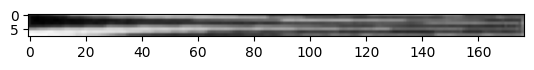

In [ ]:
# in our final_stack_f56
# Crop the horizontal sweep
H_sweep = final_stack_f56[298:308,326:503] # from 1 to 6
# Crop the vertical sweep
V_sweep = final_stack_f56[96:273,452:460] # from 1 to 6
# Rotate the vertical sweep (and make sure they have the same dimensions)
V_sweep = V_sweep.T
plt.imshow(V_sweep, cmap=mpl.colormaps['gray'])

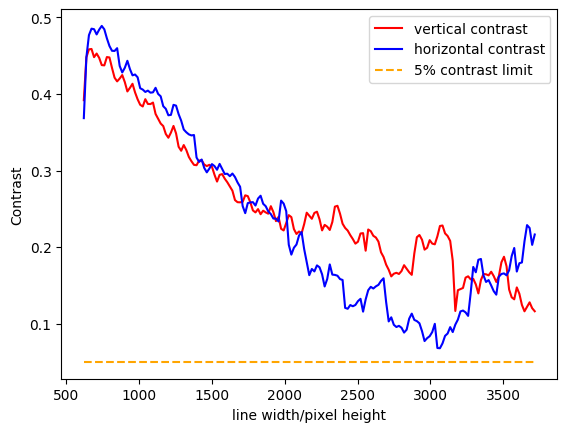

In [ ]:
# save space for contrast
H_contrast = np.zeros((H_sweep.shape[1]))
V_contrast = np.zeros((V_sweep.shape[1]))

# for each column
for col in range (H_sweep.shape[1]):
  # determine the maximum white and black values
  max_white_f56 = np.max(H_sweep[:,col])
  max_black_f56 = np.min(H_sweep[:,col])
  # calculate contrast
  H_contrast[col] = (max_white_f56 - max_black_f56)/(max_white_f56 + max_black_f56)

for col in range (V_sweep.shape[1]):
  max_white_f56 = np.max(V_sweep[:,col])
  max_black_f56 = np.min(V_sweep[:,col])
  # calculate contrast
  V_contrast[col] = (max_white_f56 - max_black_f56)/(max_white_f56 + max_black_f56)

# multiply values like in step 4
# ie your x values are based on spatial resolution
# calculate the spatial resolution for the first x value, and then the last x value
lwph_min = 100*scale*1
lwph_max = 100*scale*6

# Create graph for contrast at each point
# include the 5% line
x_axis = np.linspace(lwph_min, lwph_max, np.size(V_contrast))
plt.plot(x_axis, V_contrast, color='red')
plt.plot(x_axis, H_contrast, color='blue')
plt.plot(x_axis, [0.05]*np.size(x_axis), color='orange', linestyle='--')
plt.xlabel('line width/pixel height')
plt.ylabel('Contrast')
plt.legend(['vertical contrast', 'horizontal contrast', '5% contrast limit'])

This makes sense because our images never become fully gray/blurred. We stopped around 4.25 during step 4ish because we can't see

In [ ]:
# calculate numerically the lowest spatial resolution to drop below 5%
# if no values do so, find lowest contrast value
min_contrast_loc_horizontal = np.argmin(H_contrast)
min_contrast_loc_vertical = np.argmin(V_contrast)

min_contrast_lwph_horizontal = x_axis[min_contrast_loc_horizontal]
print(min_contrast_lwph_horizontal)
min_contrast_lwph_vertical = x_axis[min_contrast_loc_vertical]
print(min_contrast_lwph_vertical)


3066.354723707665
3647.2370766488416
